# Preprocessing OM4 data

v0.0 indicates Adams preprocessing

['leap-persistent/sd5313/OM4-5daily/19580101.ocean_5daily.nc',
 'leap-persistent/sd5313/OM4-5daily/19590101.ocean_5daily.nc',
 'leap-persistent/sd5313/OM4-5daily/ocean_hgrid.nc',
 'leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc']

I am currently trying to get virtualizarr to install cleanly and that requires numpy 2.0. 

- remove `mamba uninstall xclim geocube tiledb-py`
- `mamba update "numpy>=2.0.0"`
- `pip install virtualizarr'

In [1]:
# !pip install virtualizarr
# !pip install hidefix

In [4]:
import xarray as xr
import fsspec
import gcsfs
from virtualizarr import open_virtual_dataset

ModuleNotFoundError: No module named 'virtualizarr'

In [5]:
drop_vars = ['prlq',
 'prsn',
 'evs',
 'wfo',
 'sfdsi',
 'hfsifrazil',
 'rlntds',
 'hflso',
 'hfsso',
 'rsntds',
 'ustar',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bnds']


# taken from a `ls -la ./OM4-5daily/19580101.ocean_5daily.nc` call with a locally cached file
size = 65422554204

In [6]:
# import hidefix

In [7]:
# %%prun
# ds_local = xr.open_dataset('./OM4-5daily/19580101.ocean_5daily.nc', chunks={'time':5},  drop_variables=drop_vars)

# the file reads take forever!!! and blast out 500GIg of memory?
It seems like fsspec is caching the entire file into memory? Gosh this is stupid. 

Actually it seems to be doing that multiple times? What the heck is going on?

Some ideas:
- play with the cache_type to se if one of them works better
- Can virtualizarr read this quicker? Not sure why it would, but maybe worth a try.

In [ ]:
# # Test virtualizarr also slow (prob same issue with fsspec)
# ds = open_virtual_dataset('gs://leap-persistent/sd5313/OM4-5daily/19580101.ocean_5daily.nc')

In [ ]:
%%prun
# the 'classic' way (almost blows out the memory)


import gcsfs
fs = gcsfs.GCSFileSystem()

paths = [
    'gs://leap-persistent/sd5313/OM4-5daily/19580101.ocean_5daily.nc',
    'gs://leap-persistent/sd5313/OM4-5daily/19590101.ocean_5daily.nc'
        ]

datasets = []
for path in paths:
    print(path)
    # providing the size ahead of time so fsspec does not try to infer it (wich might just download the entire file?)
    with fs.open(path, size=size, cache_type='first') as f:
        datasets.append(xr.open_dataset(f,chunks={'time':1}))
    # # with fs.open(path) as f:
    # vds = open_virtual_dataset(
    #     path,
    #     filetype='netCDF3',
    #     drop_variables=drop_vars,
    #     loadable_variables=['time'],
    #     cftime_variables=['time']
    # )  
ds = xr.concat(datasets, dim='time')
ds

gs://leap-persistent/sd5313/OM4-5daily/19580101.ocean_5daily.nc


In [19]:
%%prun
with fsspec.open('gs://leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc', cache_type=) as f:
    ds_grid = xr.open_dataset(f)
ds_grid

         39890 function calls (39780 primitive calls) in 4.322 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      220    4.239    0.019    4.239    0.019 {method 'acquire' of '_thread.lock' objects}
       84    0.017    0.000    0.017    0.000 {method 'copy' of 'numpy.ndarray' objects}
     1544    0.017    0.000    4.201    0.003 caching.py:209(_fetch)
        2    0.013    0.007    0.013    0.007 {built-in method _socket.getaddrinfo}
     1684    0.004    0.000    4.208    0.002 spec.py:1836(read)
     1544    0.001    0.000    0.001    0.000 caching.py:82(_log_stats)
        2    0.001    0.001    0.001    0.001 {method 'recv_into' of '_socket.socket' objects}
       32    0.001    0.000    1.385    0.043 _netcdf.py:732(_read_var)
       55    0.001    0.000    0.001    0.000 {method 'send' of '_socket.socket' objects}
       55    0.001    0.000    4.245    0.077 asyn.py:63(sync)
        1    0.001    0.001    4.168

In [5]:
with fsspec.open('gs://leap-persistent/sd5313/OM4-5daily/ocean_hgrid.nc') as f:
    ds_super_grid = xr.open_dataset(f)
ds_super_grid

<xarray.Dataset> Size: 299MB
Dimensions:   (nyp: 2161, nxp: 2881, ny: 2160, nx: 2880)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    angle_dx  (nyp, nxp) float64 50MB ...
    area      (ny, nx) float64 50MB ...
    dx        (nyp, nx) float64 50MB ...
    dy        (ny, nxp) float64 50MB ...
    tile      |S255 255B ...
    x         (nyp, nxp) float64 50MB ...
    y         (nyp, nxp) float64 50MB ...

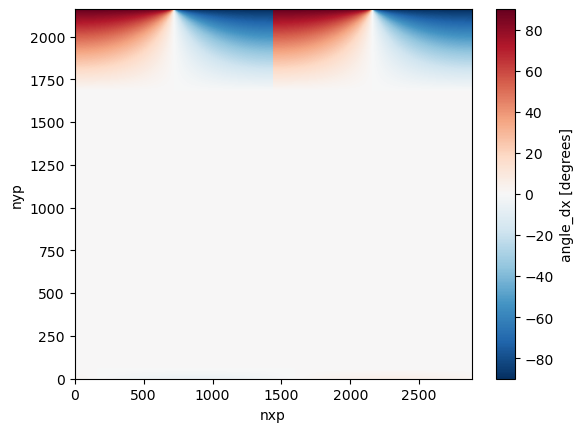

In [7]:
ds_grid.angle_dx.plot()